## 군집화 실습 - 고객 세그먼테이션
: 다양한 기준으로 고객을 분류하는 기법

### 데이터 셋 로딩과 데이터 클린징
https://archive.ics.uci.edu/ml/datasets/online+retail

#### 데이터 설명
- InvoiceNo: 송장번호. 명목, 각 거래에 고유하게 할당된 6자리 정수입니다. 이 코드가 문자 'c'로 시작하면 취소를 나타냅니다.
- StockCode: 제품(항목) 코드. 명목상, 각 고유 제품에 고유하게 할당된 5자리 정수입니다.
- Description: 제품(항목) 이름입니다. 문자열.
- Quantity: 거래당 각 제품(항목)의 수량. 숫자.
- InvoiceDate: 송장 날짜. 숫자, 각 트랜잭션이 생성된 날짜 및 시간.
- UnitPrice: 단가. 제품 가격. 숫자.
- CustomerID: 고객 번호. 호칭, 각 고객에게 고유하게 할당된 5자리 정수입니다.
- Country: 국가 이름. 명목상 각 고객이 거주하는 국가의 이름입니다.

In [8]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [9]:
print(retail_df.shape)
retail_df.info()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


#### 데이터 제외
**반품이나 CustomerID가 Null인 데이터는 제외, 영국 이외 국가의 데이터는 제외**

In [10]:
retail_df = retail_df[retail_df['Quantity'] > 0] # Qunatity가 0이하인거 제외
retail_df = retail_df[retail_df['UnitPrice'] > 0] # UnitPrice가 0이하인거 제외
retail_df = retail_df[retail_df['CustomerID'].notnull()] # 커스터머ID가 Null인거 제외
print(retail_df.shape) # 541909행에서 397884로 줄어듬.
retail_df.isnull().sum() # 컬럼별 null값 확인 -> 없음

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [4]:
# 대부분의 구매국가는 영국이다.
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [11]:
# 영국 데이터만 보기위해 나머지 국가는 삭제
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM 기반 데이터 가공
: RFM은 고객분석 기법

#### **구매금액 생성**

In [12]:
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [13]:
# 구매수량 * 단위구매가격 = 구매금액 (한 row에 해당하는 구매금액)
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
# 커스터머ID를 float에서 int로 변경
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [14]:
# 주문횟수가 많은 상위 5개 고객ID -> 거의 기업고객급으로 주문횟수가 많다. (약2000회 ~ 7800회)
print(retail_df['CustomerID'].value_counts().head(5),'\n')
# 주문금액이 많은 상위 5개 고객ID -> 골든 회원들 1등은 약 26만유로(약 3억5천만원)
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64 

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [8]:
# 송장1개당 제품 종류도 1종류인것을 확인
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

#### **고객 기준으로 Recency, Frequency, Monetary가공**
- Recency: 고객이 가장 최근에 언제 샀는지
- Frequency: 고객이 몇번 샀는지
- Monetary: 고객이 얼마치 샀는지
> CustomerID로 그룹바이하여 확인해야한다.

In [21]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max', # 주문날짜의 max -> 가장 최근이 언제인지
    'InvoiceNo': 'count', # 주문번호 개수 -> 몇번 샀는지
    'sale_amount':'sum'  # 주문금액 합 -> 총 얼마너치 샀는지
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)
# CustomerID기준으로 데이터프레임이 완성됨

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


**Recency를 날짜에서 정수형으로 가공**

In [22]:
cust_df['Recency'].max()
# 날짜 최대값이 2011-12-09

Timestamp('2011-12-09 12:49:00')

In [23]:
import datetime as dt
# 날짜 최대값 다음날 2011-12-10에서 Recency날짜를 뺸 뒤에. days+1
cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
print(f"cust_df Recency의 최소값은 {cust_df.Recency.min()}이 된다.")
cust_df.head(3)
# Recency는 현재로부터 과거 언제샀는지가 된다. 1이면 어제산거고 326이면 326일 전에 산 것

cust_df 로우와 컬럼 건수는  (3920, 4)
cust_df Recency의 최소값은 1이 된다.


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


### RFM 기반 고객 세그먼테이션

#### **Recency, Frequency, Monetary 값의 분포도 확인**

In [26]:
## 그래프 스타일 설정
plt.rcParams['xtick.color'] = 'white';plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.color'] = 'white';plt.rcParams['ytick.labelsize']=15
plt.rcParams['axes.labelcolor'] = 'white';plt.rcParams['axes.labelsize']= 17
plt.rcParams['axes.titlecolor']= 'white';plt.rcParams['axes.titlesize']= 20

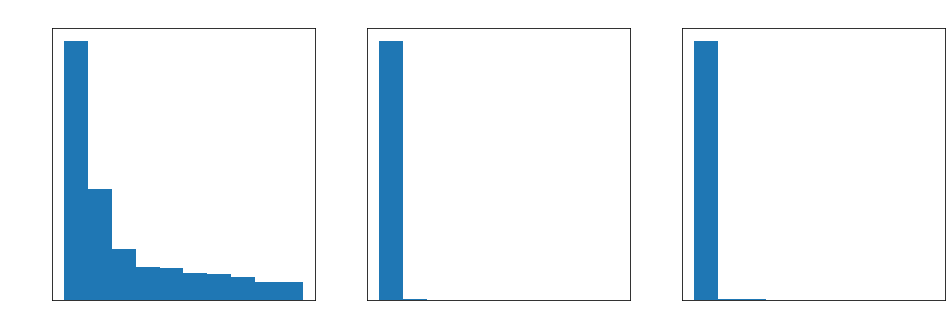

In [33]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(16,5), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])
plt.show()
# Recency를 보면 특정 고객이 매우 자주 들어와서 Right skewed된 분포를 볼 수 있다.
# Frequency와 Monetary는 훨씬 심한데, 특정 고객이 매우 자주사고, 또 금액도 많이 지불하는것을 볼 수 있다.

In [34]:
cust_df[['Recency','Frequency','Monetary']].describe()
# 좀 더 자세하게 describe로 확인
# 모두 중위값(50%)보다 평균이 매우 크다. 즉 특정 몇몇이 평균을 엄청 올렸다고 볼 수 있다.

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


#### **K-Means로 군집화 후에 실루엣 계수 평가**

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))
# 실루엣 스코어가 0.592로 수치는 굉장히 좋게 나왔다.
## -> 잘 쪼개진게 맞는지 시각화 필요

실루엣 스코어는 : 0.592


#### **K-Means 군집화 후에 실루엣 계수 및 군집을 시각화**

In [45]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(6*n_cols, 6), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [46]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(6*n_cols, 6), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

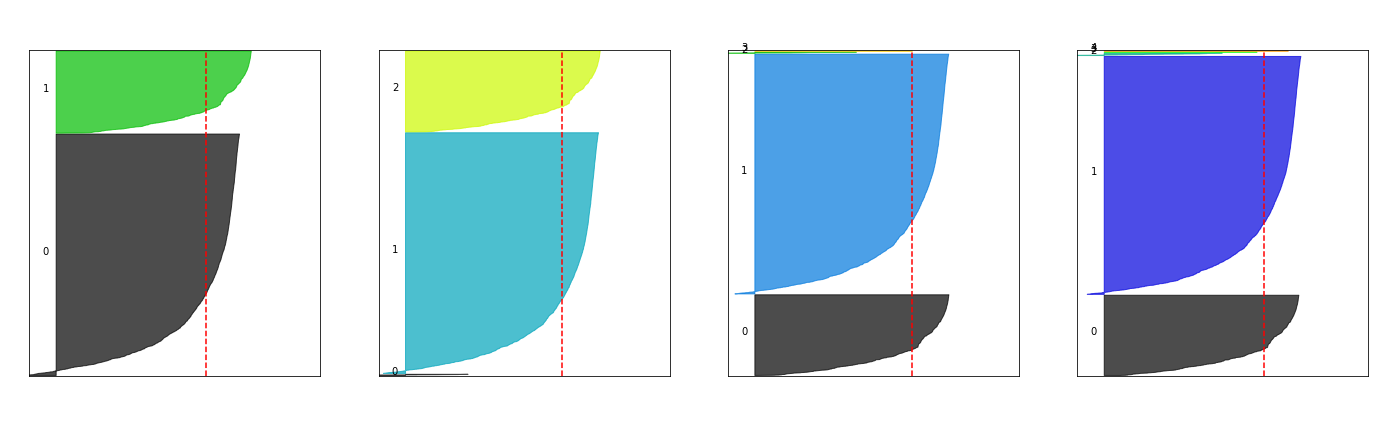

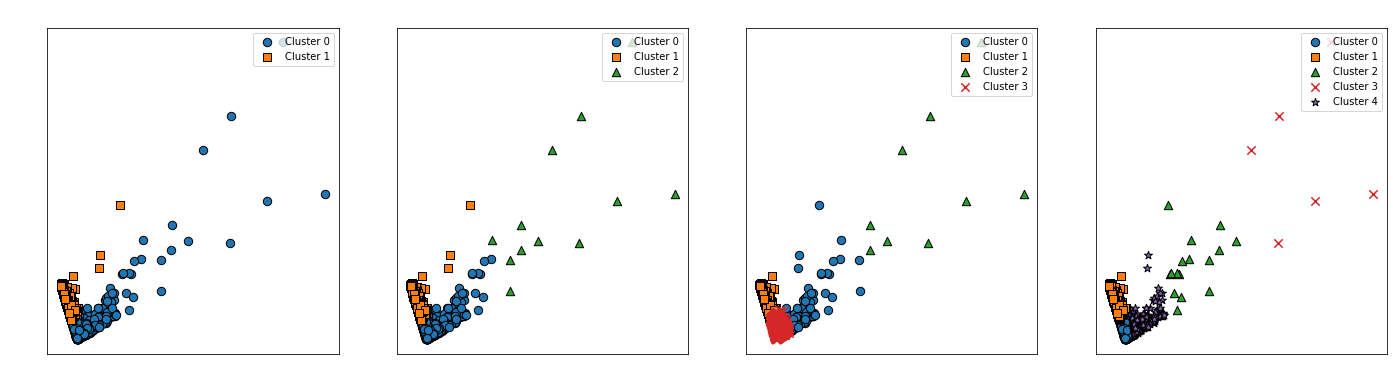

In [47]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)
plt.show()
# 클러스터별 실루엣 계수 시각화 
## 2번째는 PCA를 통해 2차원으로 축소하고, 클러스터별로 시각화

#### **로그 변환 후 재 시각화**
:위에 시각화를 보면 큰값들이 있어서 작은 값들이 몰려있게 된다 -> 로그 변환을 하고 보는게 좋다. (큰 값들의 영향도를 줄이기 위해)

In [48]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))
# 실루엣 스쿠어는 작아졌지만, 데이터 분포를 봐야한다.

실루엣 스코어는 : 0.303


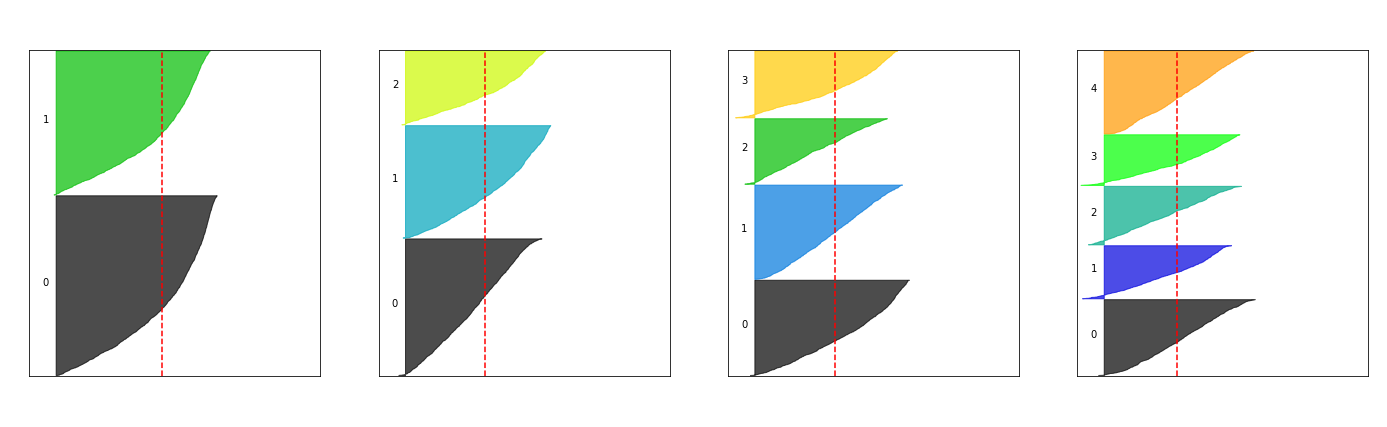

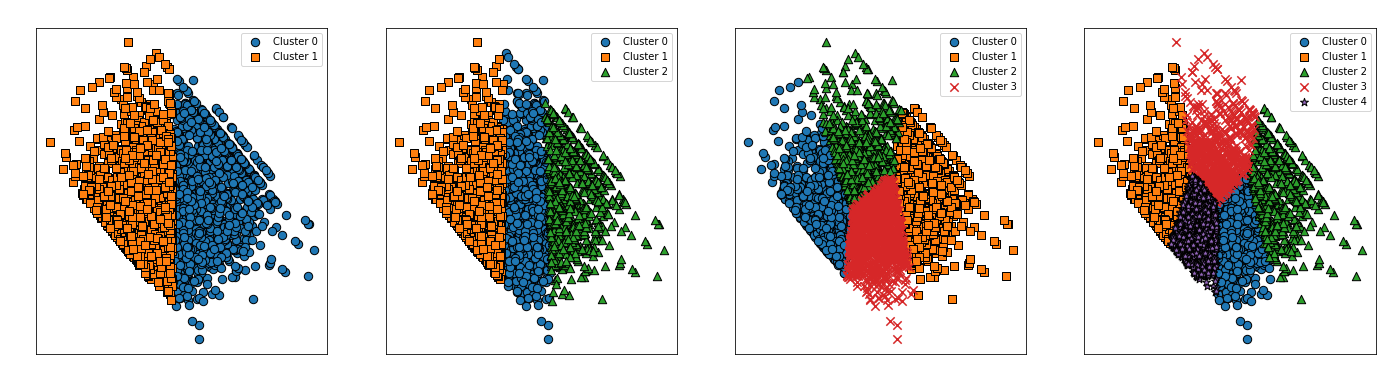

In [49]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)
# 실루엣 계수는 줄었지만, 각 클러스터별로 분류된 고객들이 균등하게 들어가는 것을 볼 수 있다.